In [98]:
import agama
import arepo
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from joblib import Parallel, delayed
import matplotlib as mpl

from numba import njit

agama.setUnits(mass=1E10, length=1, velocity=1)

'Length unit: 1 Kpc, velocity unit: 1 km/s, time unit: 977.793 Myr, mass unit: 1e+10 Msun, gravitational constant: 43009.2'

In [15]:
@njit
def my_mult(mass, vel):
    out = np.zeros((len(mass), 3))
    for i in range(len(mass)):
        out[i][0] = mass[i] * vel[i][0] 
        out[i][1] = mass[i] * vel[i][1]
        out[i][2] = mass[i] * vel[i][2]
    return out

In [16]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5']

basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities', 'ParticleIDs'],
              basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/home01/abeane/starbar/plots/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f

In [4]:
sn = read_snap(500, 0, parttype=None)
sn300 = read_snap(300, 0, parttype=None)

In [5]:
sn625 = read_snap(625, 0, parttype=None)

In [6]:
sn575 = read_snap(575, 0, parttype=None)

In [18]:
def get_pos_vel_mass_halo_bulge(sn, gas=False, center=np.array([0., 0., 0.])):
    pos_halo = sn.part1.pos.value[np.argsort(sn.part1.id)]
    vel_halo = sn.part1.vel.value[np.argsort(sn.part1.id)]
    mass_halo = np.full(sn.NumPart_Total[1], sn.MassTable[1])

    pos_disk = sn.part2.pos.value[np.argsort(sn.part2.id)]
    vel_disk = sn.part2.vel.value[np.argsort(sn.part2.id)]
    
    pos_blge = sn.part3.pos.value[np.argsort(sn.part3.id)]
    vel_blge = sn.part3.vel.value[np.argsort(sn.part3.id)]
    
    if gas:
        pos_gas = sn.part0.pos.value
        vel_gas = sn.part0.vel.value
        mass_gas = sn.part0.mass.value
        
        if sn.NumPart_Total[4]>0:
            pos_star = sn.part4.pos.value
            vel_star = sn.part4.vel.value
            mass_star = sn.part4.mass.value

    pos_bar = np.concatenate((pos_disk, pos_blge))
    vel_bar = np.concatenate((vel_disk, vel_blge))
    mass_bar = np.concatenate((np.full(sn.NumPart_Total[2], sn.MassTable[2]), \
                               np.full(sn.NumPart_Total[3], sn.MassTable[3])))

    if gas:
        pos_bar = np.concatenate((pos_bar, pos_gas))
        vel_bar = np.concatenate((vel_bar, vel_gas))
        mass_bar = np.concatenate((mass_bar, mass_gas))
        if sn.NumPart_Total[4] > 0:
            pos_bar = np.concatenate((pos_bar, pos_star))
            vel_bar = np.concatenate((vel_bar, vel_star))
            mass_bar = np.concatenate((mass_bar, mass_star))

    pos_bar -= center
    pos_halo -= center
            
    return pos_bar, vel_bar, mass_bar, pos_halo, vel_halo, mass_halo

In [7]:
pos_bar, vel_bar, mass_bar, pos_halo, vel_halo, mass_halo = get_pos_vel_mass_halo_bulge(sn)

In [8]:
pos_bar300, vel_bar300, mass_bar300, pos_halo300, vel_halo300, mass_halo300 = get_pos_vel_mass_halo_bulge(sn300)

In [10]:
pos_bar575, vel_bar575, mass_bar575, pos_halo575, vel_halo575, mass_halo575 = get_pos_vel_mass_halo_bulge(sn575)

In [11]:
pot_halo = agama.Potential(type="Multipole", particles=(pos_halo, mass_halo),
                           symmetry='a', gridsizeR=20, lmax=2)

pot_bar  = agama.Potential(type="CylSpline", particles=(pos_bar, mass_bar),
                          symmetry='a', gridsizer=20, gridsizez=20,
                          mmax=0, Rmin=0.2, Rmax=50, Zmin=0.02, Zmax=10)

In [12]:
pot_tot = agama.Potential(pot_halo, pot_bar)

In [13]:
R = np.linalg.norm(pos_bar[:,:2], axis=1)
points = np.column_stack((R, R*0, R*0))
force,deriv = pot_tot.forceDeriv(points)
kappa = np.sqrt(-deriv[:,0] - 3*force[:,0]/R)
Omega = np.sqrt(-force[:,0]/R)

In [14]:
vel_bar = np.concatenate((sn.part2.vel.value, sn.part3.vel.value))
w_bar = np.hstack((pos_bar, vel_bar))
Tcirc = pot_tot.Tcirc(w_bar)
Omega = 2.*np.pi / Tcirc

In [15]:
key = np.argmin(np.abs(R - 6))
Omega[key]

46.52926289166349

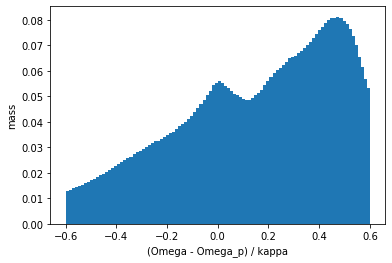

In [16]:
Omega_p = 36.93078876947825
plt.hist((Omega - Omega_p) / kappa, bins=100, weights=mass_bar, range=(-0.6, 0.6))
plt.xlabel('(Omega - Omega_p) / kappa')
plt.ylabel('mass')
# plt.xlim(-1, 1)
plt.show()

In [17]:
Lz500 = my_mult(mass_halo, np.cross(pos_halo, vel_halo))
Lz300 = my_mult(mass_halo300, np.cross(pos_halo300, vel_halo300))
dLz500 = Lz500 - Lz300

1.2068634582145971e-06


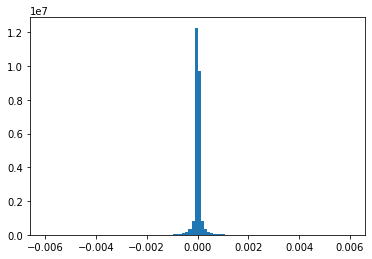

In [38]:
plt.hist(dLz500[:,2], bins=100)
mean = np.mean(dLz500)
print(mean)
mean = 0
std = np.std(dLz500)
key = np.where(np.abs(dLz500 - mean)/std > 6)[0]
plt.show()

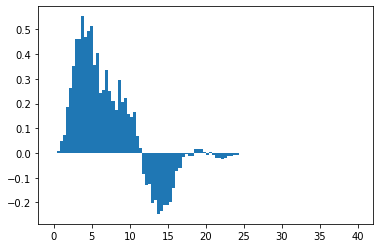

In [43]:
R300 = np.linalg.norm(pos_halo300[:,:2], axis=1)
plt.hist(R300[key], bins=100, range=[0, 40], weights=dLz500[key][:,2])
plt.show()

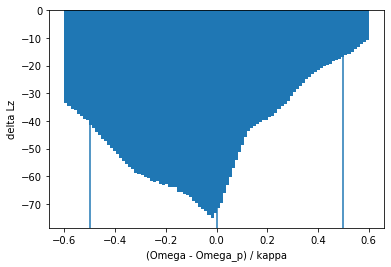

In [18]:
Omega_p = 36.93078876947825
plt.hist((Omega - Omega_p) / kappa, weights=dLz500[:,2], bins=100, range=(-0.6, 0.6))
# plt.xlim(-1, 1)
plt.axvline(0.5)
plt.axvline(0)
plt.axvline(-0.5)
plt.xlabel('(Omega - Omega_p) / kappa')
plt.ylabel('delta Lz')
plt.show()

In [19]:
pos_bar625, vel_bar625, mass_bar625, pos_halo625, vel_halo625, mass_halo625 = get_pos_vel_mass_halo_bulge(sn625)

In [20]:
pot_halo625 = agama.Potential(type="Multipole", particles=(pos_halo625, mass_halo625),
                           symmetry='a', gridsizeR=20, lmax=2)

pot_bar625  = agama.Potential(type="CylSpline", particles=(pos_bar625, mass_bar625),
                          symmetry='a', gridsizer=20, gridsizez=20,
                          mmax=0, Rmin=0.2, Rmax=50, Zmin=0.02, Zmax=10)

pot_tot625 = agama.Potential(pot_halo625, pot_bar625)

In [21]:
R = np.linalg.norm(pos_bar625[:,:2], axis=1)
points = np.column_stack((R, R*0, R*0))
force,deriv = pot_tot625.forceDeriv(points)
kappa625 = np.sqrt(-deriv[:,0] - 3*force[:,0]/R)
Omega625 = np.sqrt(-force[:,0]/R)

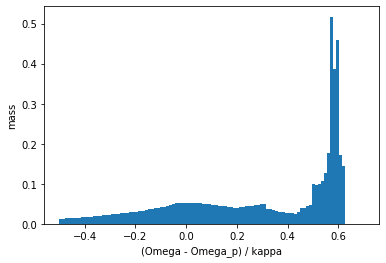

In [22]:
Omega_p = 31.536139084337588
plt.hist((Omega625 - Omega_p) / kappa625, bins=100, weights=mass_bar625, range=(-0.5, 0.7))
plt.xlabel('(Omega - Omega_p) / kappa')
plt.ylabel('mass')
# plt.xlim(-1, 1)
plt.show()

In [23]:
Lz500 = my_mult(mass_bar, np.cross(pos_bar, vel_bar))
Lz625 = my_mult(mass_bar625, np.cross(pos_bar625, vel_bar625))
dLz625 = Lz625 - Lz500

In [24]:
Lz575 = my_mult(mass_bar575, np.cross(pos_bar575, vel_bar575))
Lz625 = my_mult(mass_bar625, np.cross(pos_bar625, vel_bar625))
dLz625 = Lz625 - Lz575

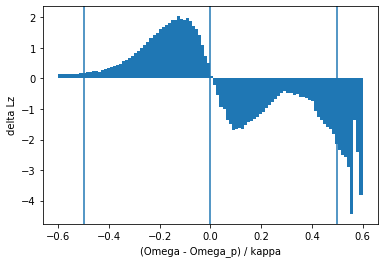

In [25]:
Omega_p = 35
plt.hist((Omega625 - Omega_p) / kappa625, weights=dLz625[:,2], bins=100, range=(-0.6, 0.6))
# plt.xlim(-1, 1)
plt.axvline(0.5)
plt.axvline(0)
plt.axvline(-0.5)
plt.xlabel('(Omega - Omega_p) / kappa')
plt.ylabel('delta Lz')
plt.show()

In [26]:
R = np.linalg.norm(pos_halo625[:,:2], axis=1)
points = np.column_stack((R, R*0, R*0))
force,deriv = pot_tot625.forceDeriv(points)
kappa625_halo = np.sqrt(-deriv[:,0] - 3*force[:,0]/R)
Omega625_halo = np.sqrt(-force[:,0]/R)

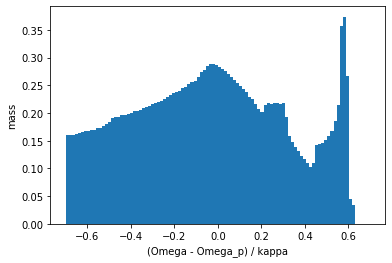

In [27]:
Omega_p = 31.536139084337588
plt.hist((Omega625_halo - Omega_p) / kappa625_halo, bins=100, weights=mass_halo625, range=(-0.7, 0.7))
plt.xlabel('(Omega - Omega_p) / kappa')
plt.ylabel('mass')
# plt.xlim(-1, 1)
plt.show()

In [28]:
Lz575 = my_mult(mass_halo575, np.cross(pos_halo575, vel_halo575))
Lz625 = my_mult(mass_halo625, np.cross(pos_halo625, vel_halo625))
dLz625_halo = Lz625 - Lz575

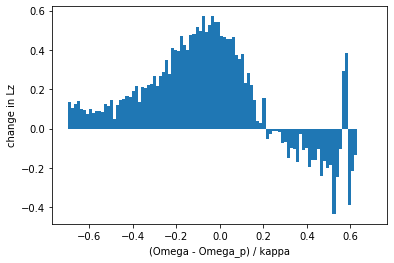

In [29]:
Omega_p = 31.536139084337588
plt.hist((Omega625_halo - Omega_p) / kappa625_halo, bins=100, weights=dLz625_halo[:,2], range=(-0.7, 0.7))
plt.xlabel('(Omega - Omega_p) / kappa')
plt.ylabel('change in Lz')
# plt.xlim(-1, 1)
plt.show()

## Redo the same calc but with gas now

In [98]:
snS500 = read_snap(500, 1, parttype=None)
snS450 = read_snap(450, 0, parttype=None)

In [114]:
pos_barS500, vel_barS500, mass_barS500, pos_haloS500, vel_haloS500, mass_haloS500 = \
  get_pos_vel_mass_halo_bulge(snS500, gas=True, center=np.array([200., 200., 200.]))

In [115]:
pos_barS500_ng, vel_barS500_ng, mass_barS500_ng, pos_haloS500_ng, vel_haloS500_ng, mass_haloS500_ng = \
  get_pos_vel_mass_halo_bulge(snS500, gas=False, center=np.array([200., 200., 200.]))
    
pos_barS450_ng, vel_barS450_ng, mass_barS450_ng, pos_haloS450_ng, vel_haloS450_ng, mass_haloS450_ng = \
  get_pos_vel_mass_halo_bulge(snS450, gas=False, center=np.array([200., 200., 200.]))

In [116]:
pot_haloS500 = agama.Potential(type="Multipole", particles=(pos_haloS500, mass_haloS500),
                           symmetry='a', gridsizeR=20, lmax=2)

pot_barS500  = agama.Potential(type="CylSpline", particles=(pos_barS500, mass_barS500),
                          symmetry='a', gridsizer=20, gridsizez=20,
                          mmax=0, Rmin=0.2, Rmax=50, Zmin=0.02, Zmax=10)

pot_totS500 = agama.Potential(pot_haloS500, pot_barS500)

In [117]:
R = np.linalg.norm(pos_barS500_ng[:,:2], axis=1)
points = np.column_stack((R, R*0, R*0))
force,deriv = pot_tot625.forceDeriv(points)
kappaS500 = np.sqrt(-deriv[:,0] - 3*force[:,0]/R)
OmegaS500 = np.sqrt(-force[:,0]/R)

In [118]:
R = np.linalg.norm(pos_haloS500_ng[:,:2], axis=1)
points = np.column_stack((R, R*0, R*0))
force,deriv = pot_tot625.forceDeriv(points)
kappaS500_halo = np.sqrt(-deriv[:,0] - 3*force[:,0]/R)
OmegaS500_halo = np.sqrt(-force[:,0]/R)

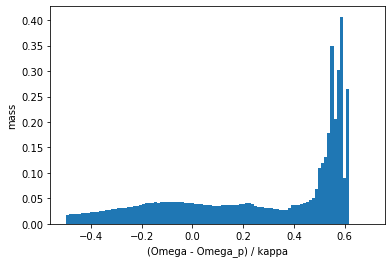

In [121]:
Omega_p = 38
plt.hist((OmegaS500 - Omega_p) / kappaS500, bins=100, weights=mass_barS500_ng, range=(-0.5, 0.7))
plt.xlabel('(Omega - Omega_p) / kappa')
plt.ylabel('mass')
# plt.xlim(-1, 1)
plt.show()

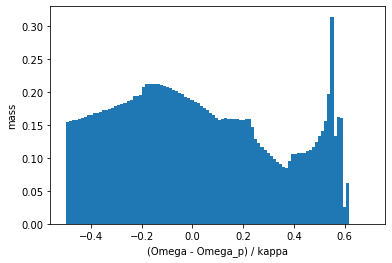

In [120]:
Omega_p = 38
plt.hist((OmegaS500_halo - Omega_p) / kappaS500_halo, bins=100, weights=mass_haloS500_ng, range=(-0.5, 0.7))
plt.xlabel('(Omega - Omega_p) / kappa')
plt.ylabel('mass')
# plt.xlim(-1, 1)
plt.show()

In [122]:
LzS500 = my_mult(mass_barS500_ng, np.cross(pos_barS500_ng, vel_barS500_ng))
LzS450 = my_mult(mass_barS450_ng, np.cross(pos_barS450_ng, vel_barS450_ng))
dLzS500 = LzS500 - LzS450

LzS500 = my_mult(mass_haloS500_ng, np.cross(pos_haloS500_ng, vel_haloS500_ng))
LzS450 = my_mult(mass_haloS450_ng, np.cross(pos_haloS450_ng, vel_haloS450_ng))
dLzS500_halo = LzS500 - LzS450

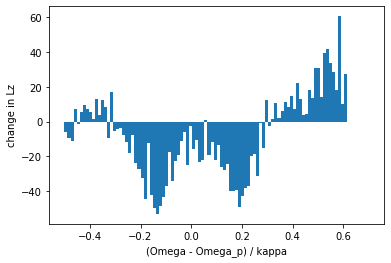

In [124]:
Omega_p = 38
plt.hist((OmegaS500 - Omega_p) / kappaS500, bins=100, weights=dLzS500[:,2], range=(-0.5, 0.7))
plt.xlabel('(Omega - Omega_p) / kappa')
plt.ylabel('change in Lz')
# plt.xlim(-1, 1)
plt.show()

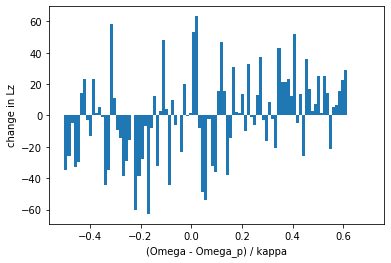

In [129]:
Omega_p = 38
plt.hist((OmegaS500_halo - Omega_p) / kappaS500_halo, bins=100, weights=dLzS500_halo[:,2], range=(-0.5, 0.7))
plt.xlabel('(Omega - Omega_p) / kappa')
plt.ylabel('change in Lz')
# plt.xlim(-1, 1)
plt.show()

## Superfreq Analysis

In [4]:
from superfreq import SuperFreq, closest_resonance
import glob

name = 'Nbody'
lvl = 'lvl4'

phase_space_path = '/n/home01/abeane/starbar/plots/phase_space/data'
nchunk = len(glob.glob(phase_space_path + '/' + name + '-' + lvl + '/phase_space_*'))

i = 0
ps = h5.File(phase_space_path + '/' + name + '-' + lvl + '/phase_space_' + name + '-' + lvl + '.' + \
             str(i)+'.hdf5', mode='r')

In [55]:
t = ps['Time']

In [120]:
j = 1001
# center = np.array([200., 200., 200.])
center = np.array([0., 0., 0.])
w = np.hstack((ps['PartType2/Coordinates'][:,j,:] - center, ps['PartType2/Velocities'][:,j,:]))

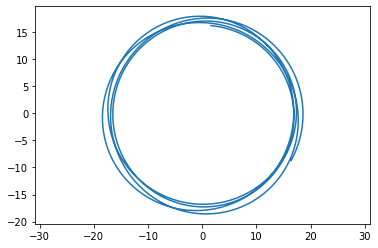

In [121]:
plt.plot(w[:400,0], w[:400,1])
plt.axis('equal')
plt.show()

[110.98677431 111.01077784 110.93600405 ... 112.41203645 112.21342153
 111.99402075]


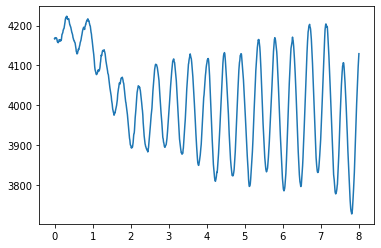

In [72]:
Lz = np.cross(w[:,:3], w[:,3:])[:,2]
R = np.linalg.norm(w[:,:2])
vphi = Lz/R
Tphi = R/vphi
print(Tphi)

plt.plot(t[:], Lz)
plt.show()

In [ ]:
plt.

In [156]:
freq_path = '/n/home01/abeane/starbar/plots/freq/data'
nchunk = len(glob.glob(freq_path + '/freq_' + name + '-' + lvl + '/freq_*'))

Omega = np.array([]).reshape((0, 3))
snap = 500
print(nchunk)

for i in tqdm(range(nchunk)):
    
    frq = h5.File(freq_path + '/freq_' + name + '-' + lvl + '/freq_' + name + '-' + lvl + '.' + \
             str(i)+'.hdf5', mode='r')
    
    Omega = np.concatenate((Omega, frq['PartType1/Frequencies'][:,snap,:]))

512


A Jupyter Widget

## Corotation resonance

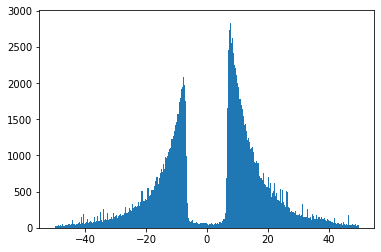

In [167]:
Omega_p = 40.0

plt.hist(Omega[:,1], bins=2000, range=(-50, 50))
plt.show()

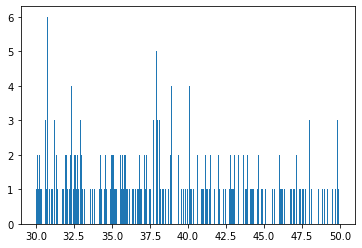

In [159]:
Omega_p = 40.0

ILR = Omega[:,1] - 0.5 * Omega[:,0]

plt.hist(ILR, bins=2000, range=(30, 50))
plt.show()

In [9]:
def read_chunk(freq_path, name, lvl, i, snap):
    frq = h5.File(freq_path + '/freq_' + name + '-' + lvl + '/freq_' + name + '-' + lvl + '.' + \
             str(i)+'.hdf5', mode='r')
    ans = np.array(frq['PartType1/Frequencies'][:,snap,:])
    frq.close()
    return ans

In [112]:
freq_path = '/n/home01/abeane/starbar/plots/freq/data'

name = 'phantom-vacuum-Sg20-Rc3.5'
lvl='lvl3'

nchunk = len(glob.glob(freq_path + '/freq_' + name + '-' + lvl + '/freq_*'))
nproc = 32

Omega_S = np.array([]).reshape((0, 3))
snap = 500
print(nchunk)

out = Parallel(n_jobs=nproc) (delayed(read_chunk)(freq_path, name, lvl, i, snap) for i in tqdm(range(nchunk)))
Omega_S = np.concatenate(out)

1024


A Jupyter Widget

In [110]:
freq_path = '/n/home01/abeane/starbar/plots/freq/data'

name = 'Nbody'
lvl='lvl3'

nchunk = len(glob.glob(freq_path + '/freq_' + name + '-' + lvl + '/freq_*'))
nproc = 32

snap = 500
print(nchunk)

out = Parallel(n_jobs=nproc) (delayed(read_chunk)(freq_path, name, lvl, i, snap) for i in tqdm(range(nchunk)))
Omega_N = np.concatenate(out)

1024


A Jupyter Widget

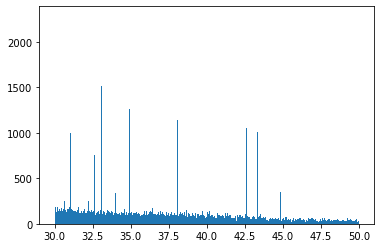

In [14]:
Omega_p = 40.0

plt.hist(Omega_S[:,1], bins=4000, range=(30, 50))
plt.show()

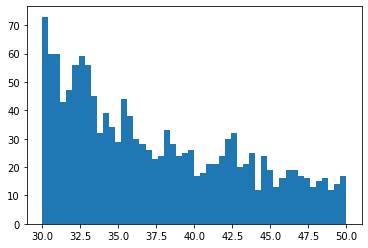

In [172]:
Omega_p = 40.0

ILR = Omega_S[:,1] - 0.5 * Omega_S[:,0]

plt.hist(ILR, bins=50, range=(30, 50))
plt.show()

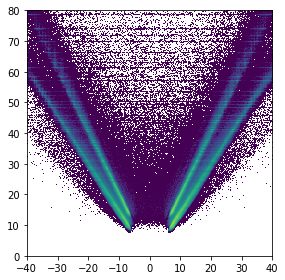

In [113]:
nres = 512

range_xy = [[-40, 40], [0, 80]]

x = Omega_S[:,1]
y = Omega_S[:,0]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

ax.imshow(heatmap_xy.T, extent=extent, origin='lower', vmin=10, vmax=1E4, norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()

plt.show()


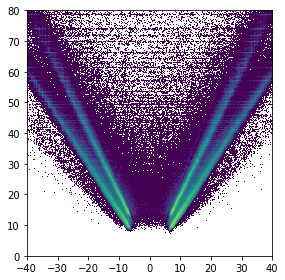

In [111]:
nres = 512

range_xy = [[-40, 40], [0, 80]]

x = Omega_N[:,1]
y = Omega_N[:,0]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

ax.imshow(heatmap_xy.T, extent=extent, origin='lower', vmin=10, vmax=1E4, norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()

plt.show()


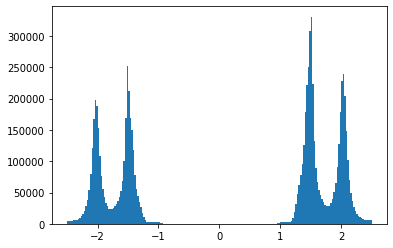

In [119]:
plt.hist(Omega_S[:,0]/Omega_S[:,1], bins=200, range=(-2.5, 2.5))
plt.show()

## AGAMA Frequencies

In [90]:
sn = read_snap(500, 0, parttype=None)

In [19]:
pos_bar, vel_bar, mass_bar, pos_halo, vel_halo, mass_halo = get_pos_vel_mass_halo_bulge(sn)

In [20]:
pot_halo = agama.Potential(type="Multipole", particles=(pos_halo, mass_halo),
                           symmetry='a', gridsizeR=20, lmax=2)

pot_bar  = agama.Potential(type="CylSpline", particles=(pos_bar, mass_bar),
                          symmetry='a', gridsizer=20, gridsizez=20,
                          mmax=0, Rmin=0.2, Rmax=50, Zmin=0.02, Zmax=10)

pot_tot = agama.Potential(pot_halo, pot_bar)

In [21]:
af = agama.ActionFinder(pot_tot)

In [91]:
points = np.hstack((sn.part1.pos.value, sn.part1.vel.value))
print(len(points))

25347840


In [92]:
%time act, ang, freq = af(points[:1000000], angles=True)

CPU times: user 2min, sys: 887 ms, total: 2min 1s
Wall time: 2min 1s


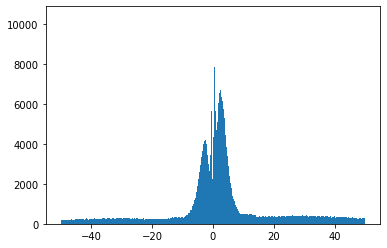

In [96]:
plt.hist(2.*np.pi*freq[:,2], bins=1000, range=(-50, 50))
plt.show()

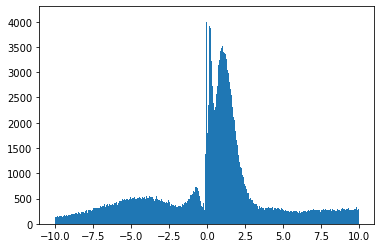

In [94]:
ILR = freq[:,2] - 0.5 * freq[:,0]
plt.hist(2.*np.pi*ILR, bins=1000, range=(-10, 10))
plt.show()

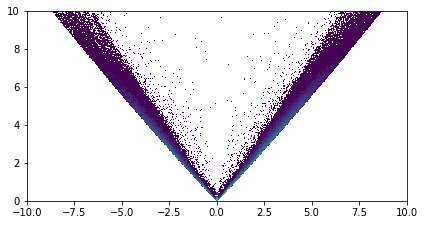

In [104]:
nres = 512

range_xy = [[-10, 10], [0, 10]]

x = 2.*np.pi*freq[:,2]
y = 2.*np.pi*freq[:,0]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

ax.imshow(heatmap_xy.T, extent=extent, origin='lower', vmin=10, vmax=1E4, norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()

plt.show()


In [56]:
snS = read_snap(500, 1, parttype=None)

In [59]:
pos_bar, vel_bar, mass_bar, pos_halo, vel_halo, mass_halo = \
        get_pos_vel_mass_halo_bulge(snS, gas=True, center=np.array([200., 200., 200.]))

In [60]:
pot_halo_S = agama.Potential(type="Multipole", particles=(pos_halo, mass_halo),
                           symmetry='a', gridsizeR=20, lmax=2)

pot_bar_S  = agama.Potential(type="CylSpline", particles=(pos_bar, mass_bar),
                          symmetry='a', gridsizer=20, gridsizez=20,
                          mmax=0, Rmin=0.2, Rmax=50, Zmin=0.02, Zmax=10)

pot_tot_S = agama.Potential(pot_halo_S, pot_bar_S)

In [75]:
af_S = agama.ActionFinder(pot_tot_S)

In [79]:
center = np.array([200., 200., 200.])
points_S = np.hstack((snS.part1.pos.value - center, snS.part1.vel.value))
print(len(points))

25347840


In [80]:
%time actS, angS, freqS = af_S(points_S[:1000000], angles=True)

CPU times: user 1min 55s, sys: 869 ms, total: 1min 56s
Wall time: 1min 56s


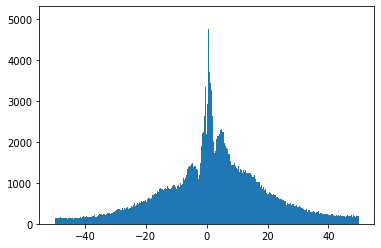

In [84]:
plt.hist(2.*np.pi*freqS[:,2], bins=1000, range=(-50, 50))
plt.show()

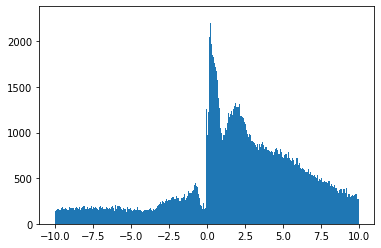

In [82]:
ILR = freqS[:,2] - 0.5 * freqS[:,0]
plt.hist(2.*np.pi*ILR, bins=1000, range=(-10, 10))
plt.show()

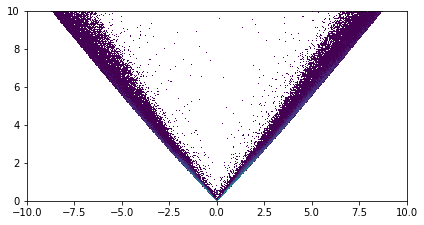

In [105]:
nres = 512

range_xy = [[-10, 10], [0, 10]]

x = 2.*np.pi*freqS[:,2]
y = 2.*np.pi*freqS[:,0]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

ax.imshow(heatmap_xy.T, extent=extent, origin='lower', vmin=10, vmax=1E4, norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()

plt.show()
